## CRM with kriging demo

In this notebook we apply the basic CRM model to production data from the COSTA reservoir model.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import Adam

sys.path.append('..')
from src import (CRM, coords_scaling, get_intersection_period, make_data, to_tensors,
                 get_statistics, show_well, train_model, show_predictions, show_res_map,
                 show_fields, compute_metrics)

### Read production data

In [2]:
df = pd.read_csv('../data/data_costa.csv')
df.date = pd.to_datetime(df.date)
df.head()

,cat,date,gor,gas,oil,watercut,water,liquid,bhp,group,water_inj,bhp_inj
0,well-1,2025-02-01,731.414978,3567828.491,4877.981171,0.000046,0.002222,4877.983393,3132.787350,P,NaN,NaN
1,well-1,2025-03-01,731.414978,3662806.889,5007.836862,0.000064,0.003183,5007.840045,3090.725933,P,NaN,NaN
2,well-1,2025-04-01,731.414978,3626328.764,4957.963500,0.000050,0.002470,4957.965970,3059.375781,P,NaN,NaN
3,well-1,2025-05-01,731.414978,3740977.563,5114.712817,0.000048,0.002431,5114.715248,3039.715643,P,NaN,NaN
4,well-1,2025-06-01,731.414978,3657318.659,5000.333284,0.000051,0.002528,5000.335813,3015.697719,P,NaN,NaN


### Read and scale coordinates

In [3]:
coords = pd.read_csv('../data/coords_costa.csv')
coords = coords_scaling(coords).set_index('cat')
coords.head()

,x,y,group,xn,yn
cat,,,,,
inj-1,49374.998177,75374.998596,I,0.449102,0.45509
inj-2,49374.998177,77874.996691,I,0.449102,0.51497
inj-3,54374.999129,75374.998596,I,0.568862,0.45509
inj-4,54374.999129,77874.996691,I,0.568862,0.51497
inj-5,44374.998415,75374.998596,I,0.329341,0.45509


### Show well's locations 

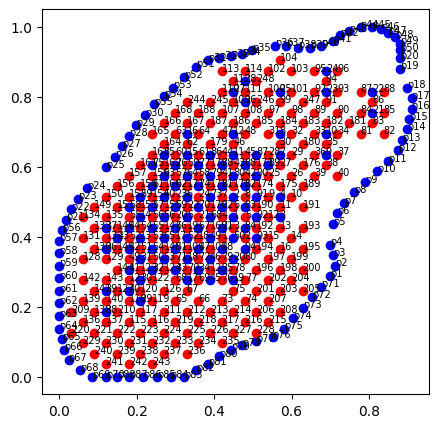

In [4]:
fig, ax = plt.subplots(1, figsize=(5, 5))
plt.scatter(*coords.loc[coords.group == 'I', ['xn', 'yn']].values.T, c='b')
plt.scatter(*coords.loc[coords.group == 'P', ['xn', 'yn']].values.T, c='r')
coords.apply(lambda x: plt.text(x.xn, x.yn, x.name.split('-')[1], fontdict={'fontsize': 7}), axis=1)
plt.show()

### Get the start and end date of the common production time period

In [5]:
dmin, dmax = get_intersection_period(df)
dmin, dmax

(datetime.date(2040, 2, 1), datetime.date(2050, 1, 1))

### Organize production date

In [6]:
wells_data = make_data(df, dmin=dmin, dmax=dmax)

### Train/test split by wells

In [7]:
np.random.seed(1234)
well_names = list(wells_data.keys())

train_wells = np.random.choice(np.array(well_names), int(len(wells_data) * 0.7), replace=False)
test_wells = np.array([k for k in well_names if k not in train_wells])

train_data = {k:wells_data[k] for k in train_wells}
test_data = {k:wells_data[k] for k in test_wells}

len(train_wells), len(test_wells)

(173, 75)

### Get statistics for data normalization

In [8]:
stats = get_statistics(train_data)
stats

{'mean_rate': 1198.2368743208265,
 'mean_pres': 2705.0574695370906,
 'mean_inj': 1810.8245949265092}

### Show sample data

In [9]:
show_well(wells_data)

interactive(children=(Dropdown(description='Well:', options=(('well-1', 'well-1'), ('well-10', 'well-10'), ('w…

### Prepare torch tensors

In [10]:
test_start = pd.to_datetime('2047-01-01')
train_ds = to_tensors(train_data, coords, stats, test_start)

### Init CRM model

In [11]:
model = CRM(n=len(train_wells), tau_min=0.1, J_min=0.1, f_min=0.1)
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.000)
loss_hist = []

### Train model

In [12]:
lh = train_model(model, n_iters=5000, dataset=train_ds, optimizer=optimizer)
loss_hist.extend(lh)

100%|█████████████████████████████████████████████████████████| 5000/5000 [00:16<00:00, 307.81it/s]


### Show loss

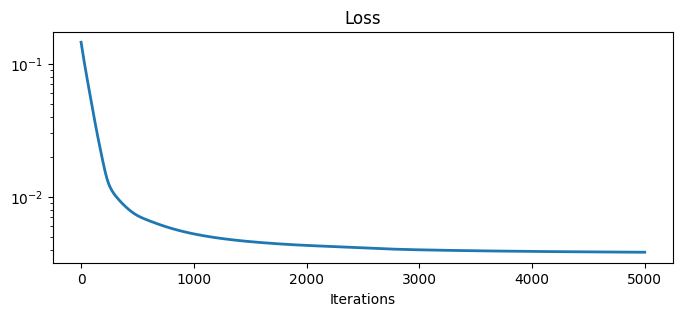

In [13]:
fig = plt.figure(figsize=(8, 3))
fig.patch.set_facecolor('xkcd:white')
plt.semilogy(np.array(loss_hist)[0:], lw=2)
plt.title('Loss')
plt.xlabel('Iterations')
plt.show()

### Fit interpolator (ordinary kriging)

In [14]:
model.fit_kriging(coords.loc[train_wells, ['xn', 'yn']].values)

### Show variograms

C:\Users\E.Illarionov\AppData\Local\Continuum\anaconda3\envs\crm\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


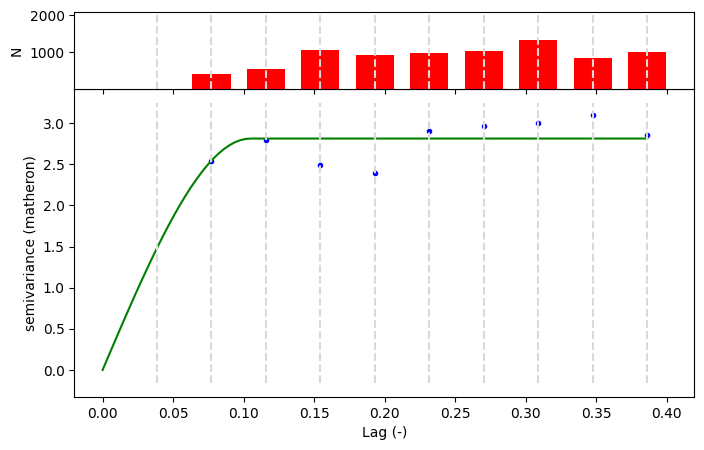

In [15]:
model.V_tau.plot()
plt.show()

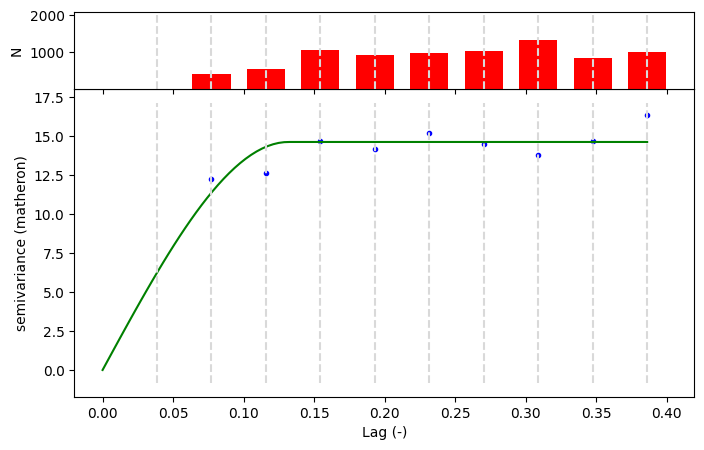

In [16]:
model.V_J.plot()
plt.show()

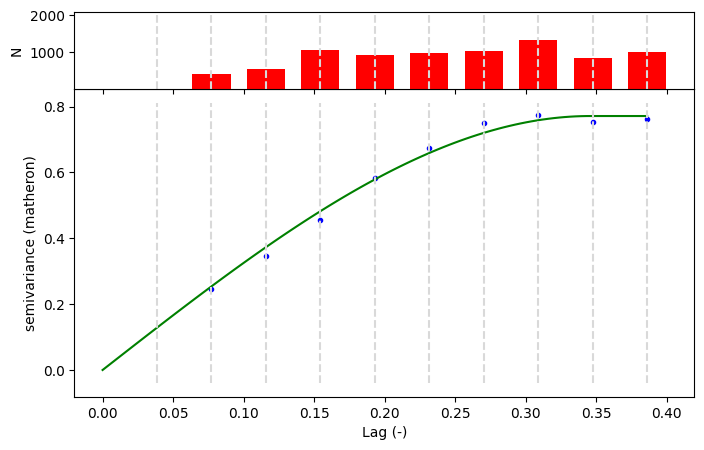

In [17]:
model.V_f.plot()
plt.show()

### Show fields

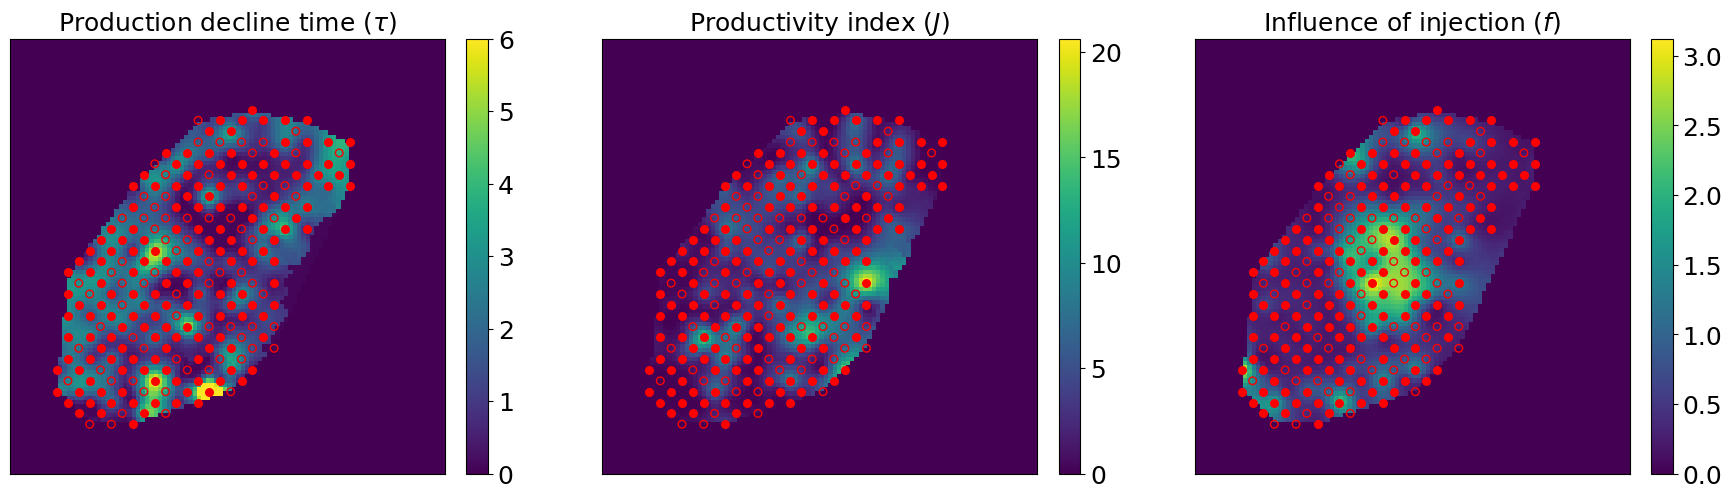

In [18]:
x = y = np.linspace(-0.1, 1.1, 100)

show_fields(model, coords.loc[well_names], x, y, show_names=False, figsize=(18, 5), 
            train_wells=train_wells, test_wells=test_wells)

### Show predictions

In [19]:
full_ds = to_tensors(wells_data, coords, stats, test_start)

show_predictions(model=model, dataset=full_ds, test_start=test_start)

interactive(children=(Dropdown(description='Well:', options=(('well-1', 'well-1'), ('well-10', 'well-10'), ('w…

### Compute metrics

In [20]:
errs = compute_metrics(model, full_ds)
errs.head()

,r2_train,mape_train,rmse_train,r2_test,mape_test,rmse_test
well,,,,,,
well-1,0.916854,0.051064,56.992925,-4.642870,0.076120,159.687573
well-10,0.112255,0.048490,72.710229,-1.591418,0.064567,81.994801
well-100,-8.251705,0.244806,265.519207,-114.907840,0.793317,581.740309
well-101,-73.282558,0.814309,529.719728,-96.230462,1.122021,622.441509
well-102,0.928079,0.028167,85.583583,0.629245,0.019294,41.398210


### Distribution of residuals

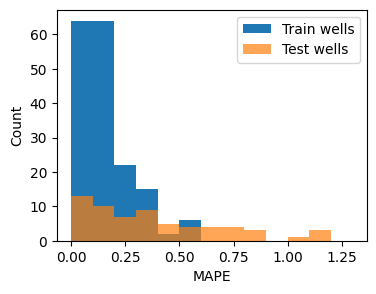

In [21]:
plt.figure(figsize=(4, 3))
bins = np.linspace(0, 1.3, 14)
plt.hist(errs.loc[train_wells].mape_test, bins=bins, label='Train wells')
plt.hist(errs.loc[test_wells].mape_test, alpha=0.7, bins=bins, label='Test wells')
plt.xlabel('MAPE')
plt.ylabel('Count')
plt.legend()
plt.show()

### Map of residuals

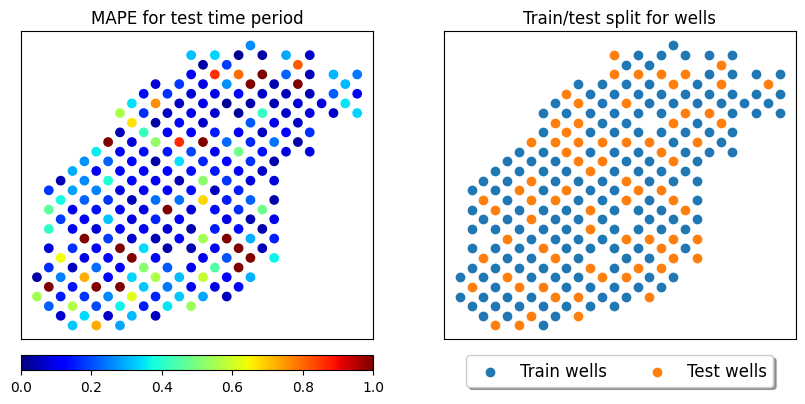

In [22]:
show_res_map(errs, coords, train_wells, test_wells, metrics='mape_test', upper=1.)

### Averaged metrics

In [23]:
print('MAPE train wells test time period:', errs.loc[train_wells].mape_test.mean())
print('MAPE test wells test time period:', errs.loc[test_wells].mape_test.mean())

MAPE train wells test time period: 0.16020591239260507
MAPE test wells test time period: 0.5947684869989713


In [24]:
torch.__version__

'1.11.0+cpu'

Done!